In [1]:
import numpy as np

from unityagents import UnityEnvironment
from tqdm import tqdm

from agent import Agent
from utils import StateAggregator

import matplotlib.pyplot as plt

## Training summary

In [2]:
train_scores = np.load('./scores.npy')

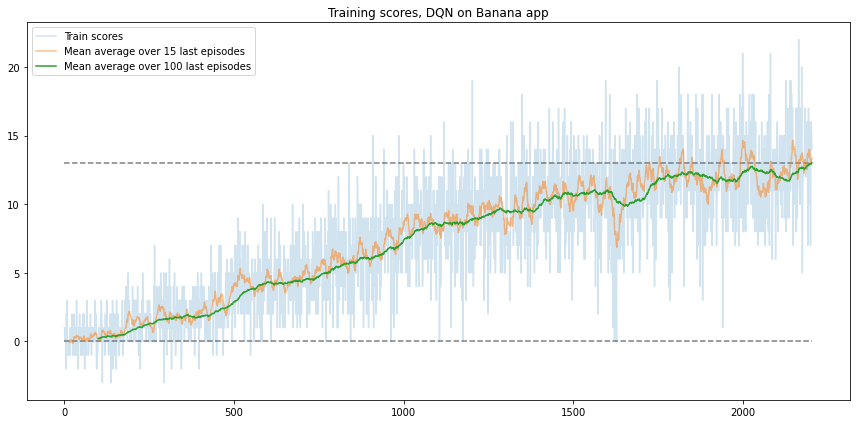

In [3]:
def mean(data, length):
    cs = np.cumsum(data)
    mean100 = np.array((cs[length:]-cs[:-length])/length)
    trailing_zeros = np.repeat(np.NaN, length)
    return np.hstack([trailing_zeros, mean100])


plt.figure(figsize=(12,6))

plt.hlines(13,0,len(train_scores), linestyle='--', alpha=0.5)
plt.hlines(0,0,len(train_scores), linestyle='--', alpha=0.5)

plt.plot(train_scores, alpha=0.2, label="Train scores")
plt.plot(mean(train_scores, 15), alpha=0.5, label="Mean average over 15 last episodes")
plt.plot(mean(train_scores, 100), label="Mean average over 100 last episodes")

plt.title('Training scores, DQN on Banana app')
plt.legend()
plt.tight_layout()
pass

## Play after training

In [4]:
# Create and setup environment
env = UnityEnvironment(file_name="./Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
max_moves = 300

# Print environment stats
print('Number of agents:', len(env_info.agents))
print('Number of actions:', action_size)
print('States look like:', state)
print('States have length:', state_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [5]:
# Play preparation
frames = 4
agent = Agent(state_size*frames, action_size)

=== AGENT ===
Created agent on device: cpu
Loaded agent model: model.pth


In [6]:
def play(env, brain_name, agent):
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]             # get the current state                                         # initialize the score
    moves=0
    score=0
    state_agg = StateAggregator(state, frames)
    while True:
        action = agent.act(state_agg.to_input(), 0)    # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score

        state_agg.push(next_state) 

        moves+=1

        if done:                                       # exit loop if episode finished
            break

    return score

In [7]:
# Play
scores = []
for i in tqdm(range(100)):
    scores.append(play(env, brain_name, agent))

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


In [8]:
env.close()

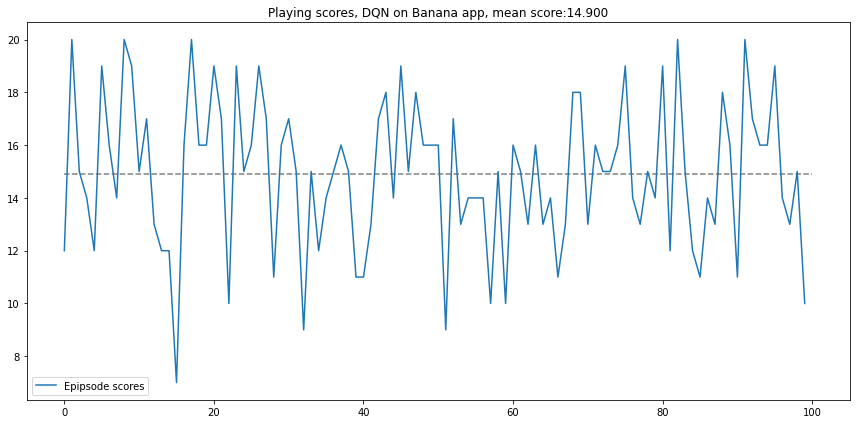

In [12]:
mean_score = np.mean(scores)
plt.figure(figsize=(12,6))
plt.hlines(mean_score,0,100, linestyle='--', alpha=0.5)
plt.plot(scores, label="Epipsode scores")

plt.title(f'Playing scores, DQN on Banana app, mean score:{mean_score:0.3f}')
plt.legend()
plt.tight_layout()

## Video recording to gif preparation

In [30]:
import skvideo.io
import skvideo.datasets
import cv2

In [41]:
frames = []
try:
    reader = skvideo.io.FFmpegReader("./demo.mov")
    for frame in reader.nextFrame():
        frame = cv2.pyrDown(frame)
        frame = cv2.pyrDown(frame)
        frame = cv2.pyrDown(frame)
        frames.append(frame)
except:
    pass

In [42]:
import imageio
imageio.mimsave('demo.gif', frames, format='GIF', duration=0.01)